# mXRF measurement analysis- Bruker fitting

**This routine opens the .txt file of measurement and analysis results from a grid of single .spx spectra that have been fit for element peaks by Bruker software (version:  )**

*Date:  20230530*

*Author:  Donald Windover, NIST*

## Notebook description and input files

### Date and time: When the notebook is started

In [1]:
from datetime import datetime
# datetime object containing current date and time
now = datetime.now() 
print("now =", now)

now = 2023-08-03 15:35:49.546283


### General info:

- Reading single .txt format
- mapping Si, Hf, and Hf/Si net counts
- Looking for outliers (dust?)
- raw>process directories

### Files and directories used for fitting

- specify the location to load  .txt data (raw)
- specify the location to save processed results (data), and generated figures (data)
- specify file name
- specify new name extensions

In [2]:
TextFile = '20230323_KRISS_K157_502_6_0nm_net_sums.txt'
TextFileDir = '20230323_KRISS_K157_502_6_0nm\\'
TextFileStrip = '20230323_KRISS_K157_319_6_0nm_60s_10x10ptsdet'
Sample = "6_nm_"
Sample_name = "6 nm "

## Python import and environment versions used in this analysis

### Python environment packages for version info/dependency reproducibility

In [3]:
conda list

# packages in environment at H:\anaconda3\envs\KRISS_K157_XRF_FY23:
#
# Name                    Version                   Build  Channel
anyio                     3.7.0              pyhd8ed1ab_1    conda-forge
aom                       3.5.0                h63175ca_0    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py38h91455d4_3    conda-forge
arrow                     1.2.3              pyhd8ed1ab_0    conda-forge
asciitree                 0.3.3                      py_2    conda-forge
ase                       3.22.1             pyhd8ed1ab_1    conda-forge
asttokens                 2.2.1              pyhd8ed1ab_0    conda-forge
attrs                     23.1.0             pyh71513ae_1    conda-forge
autopep8                  2.0.2              pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0   

### Importing packages used

In [4]:
import pickle as pkl
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import PyMca5 as mca
import os
import gzip
import re as re
from importlib.metadata import version
%matplotlib inline

### Checking versions imported

In [5]:
print('pandas: ' + version('pandas')  +
      ', numpy: ' + version('numpy') +
     ', matplotlib: ' + version('matplotlib') +
     ', PyMca5: ' + version('PyMca5'))

pandas: 2.0.2, numpy: 1.24.3, matplotlib: 3.7.1, PyMca5: 5.8.3


## mXRF fitting

### building the subdirectory tree for all imports and exports
* uses import os command to find current working directory of this notebook
* generates directory tree from this root location assuming a `cookiecutter` data science directory tree.

In [6]:
# Set by cookiecutter structure
FiguresSuffix = 'figures\\'
RawSuffix = '\\data\\raw\\'
InterimSuffix = '\\data\interim\\'
ProcessedSuffix = '\\data\\processed\\'
ModelSuffix = '\\models\\'

# Find the Current Working Directory set by the notebook location
NoteBookDir = os.getcwd()
# find root of notebooks Directory
NoteBookRootDir = os.path.split(NoteBookDir)[0]
# Back up one directories (assuming that the notebook is at the notebook root)
ProjectDir = os.path.split(NoteBookRootDir)[0]
# set by notebook being 1 down from project root directory
#ProjectDir = os.path.split(ProjectDir)[0]
# build directory links independent of OS and directory location of repo.
RawDir = ProjectDir + RawSuffix
InterimDir = ProjectDir + InterimSuffix
InterimFigDir = ProjectDir + InterimSuffix + FiguresSuffix
ProcessedDir = ProjectDir + ProcessedSuffix
ProcessedFigDir = ProjectDir + ProcessedSuffix + FiguresSuffix
ModelDir = ProjectDir + ModelSuffix
raw_dir = RawDir
interim_dir = InterimDir
NoteBookDir, ProjectDir, RawDir, InterimDir, InterimFigDir, ProcessedDir, ProcessedFigDir, ModelDir

('H:\\KRISS_K157_XRF_FY23\\kriss_k157_xrf_fy23\\notebooks\\K157_502_6_0nm',
 'H:\\KRISS_K157_XRF_FY23\\kriss_k157_xrf_fy23',
 'H:\\KRISS_K157_XRF_FY23\\kriss_k157_xrf_fy23\\data\\raw\\',
 'H:\\KRISS_K157_XRF_FY23\\kriss_k157_xrf_fy23\\data\\interim\\',
 'H:\\KRISS_K157_XRF_FY23\\kriss_k157_xrf_fy23\\data\\interim\\figures\\',
 'H:\\KRISS_K157_XRF_FY23\\kriss_k157_xrf_fy23\\data\\processed\\',
 'H:\\KRISS_K157_XRF_FY23\\kriss_k157_xrf_fy23\\data\\processed\\figures\\',
 'H:\\KRISS_K157_XRF_FY23\\kriss_k157_xrf_fy23\\models\\')

### importing data from .txt file

- data has been previously fit using Bruker software
- data is split by dectector into D1 and D2

In [7]:
mXRFNetSumDF = pd.read_csv(RawDir + TextFileDir + TextFile, sep = ' ', skiprows = 2, skipfooter=5, comment = '-', skipinitialspace=True, engine = 'python')
mXRFNetSumDF['Spectrum'].replace(TextFileStrip,Sample, regex=True, inplace=True)

#mXRFNetSumDF['Spectrum'], TextFileStrip
D1 = mXRFNetSumDF[0:100]
D2 = mXRFNetSumDF[100:200]
D1, D2

(       Spectrum       Si    Ni     Rh     Hf
 0   6_nm__1_0_0   115495   132     42    723
 1   6_nm__1_0_1  1162921  2296  15146  16395
 2   6_nm__1_0_2  1157511  2469  17134  15955
 3   6_nm__1_0_3  1158076  2256  17401  15973
 4   6_nm__1_0_4  1156744  2524  17855  15499
 ..          ...      ...   ...    ...    ...
 95  6_nm__1_9_5  1142336  2320  15317  15900
 96  6_nm__1_9_6  1141750  2154  14555  15912
 97  6_nm__1_9_7  1139020  2403  14647  15362
 98  6_nm__1_9_8  1142392  2260  14628  15605
 99  6_nm__1_9_9  1143416  2311  14424  15979
 
 [100 rows x 5 columns],
         Spectrum       Si    Ni     Rh     Hf
 100  6_nm__2_0_0   121990   154     34   1201
 101  6_nm__2_0_1  1200226  2182  10832  15629
 102  6_nm__2_0_2  1200323  2110  11994  15178
 103  6_nm__2_0_3  1196398  2137  12053  15908
 104  6_nm__2_0_4  1196883  2018  12124  15340
 ..           ...      ...   ...    ...    ...
 195  6_nm__2_9_5  1181343  2199  11432  15809
 196  6_nm__2_9_6  1180808  2185  11534  1582

### Data inspected
- data is plotted using z score to determine any issues with the collection
- Si peak is used for analysis of tube intensity (Si should be stable?)

In [8]:
D1_Z = sp.stats.zscore(D1['Si'])
D2_Z = sp.stats.zscore(D2['Si'])


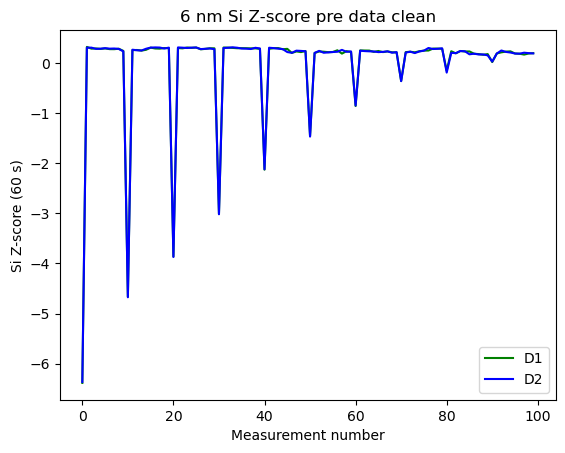

In [9]:
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 0.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 0.0),  # blue  with alpha = 20%
})


fig, ax = plt.subplots()
ax.plot(D1.index.values, sp.stats.zscore(D1_Z), color = "g", label = 'D1')
ax.plot(D1.index.values, sp.stats.zscore(D2_Z), color = "b", label = 'D2')
ax.set_title(Sample_name + 'Si Z-score pre data clean')
ax.set_xlabel('Measurement number')
ax.set_ylabel('Si Z-score (60 s)')
ax.legend()
plt.savefig(ProcessedFigDir + Sample + 'Si_Z-score_pre_clean' + '.png', dpi=600)
plt.show()

### Data clean step
- Keep only the 25% to 75% range of values from measurement (cull 50% of the data outliers)
- Repeat for both D1 and D1

In [10]:
D1Max = D1['Si'].describe()['75%']
D1Min = D1['Si'].describe()['25%']
D1_filtered = D1[(D1['Si'] >= D1Min) & (D1['Si'] <= D1Max)]
#
D2Max = D2['Si'].describe()['75%']
D2Min = D2['Si'].describe()['25%']
D2_filtered = D2[(D2['Si'] >= D2Min) & (D2['Si'] <= D2Max)]
#
D1_filtered.describe()

,Si,Ni,Rh,Hf
count,5.000000e+01,50.000000,50.000000,50.000000
mean,1.151424e+06,2338.160000,15707.880000,15927.640000
std,3.865586e+03,113.712915,793.961178,331.105061
min,1.146046e+06,2090.000000,14668.000000,15279.000000
25%,1.148386e+06,2272.000000,15184.750000,15726.250000
50%,1.150374e+06,2342.000000,15476.000000,15922.000000
75%,1.155540e+06,2418.000000,15961.750000,16139.250000
max,1.157642e+06,2579.000000,17855.000000,16671.000000


In [11]:
D1_filtered['Si'].describe()['std']/D1_filtered['Si'].describe()['mean']*100 #% uncertainty in Si

0.3357223279059674

### data inspection
- post clean up z-score

In [12]:
D1_f_Z = sp.stats.zscore(D1_filtered['Si'])
D2_f_Z = sp.stats.zscore(D2_filtered['Si'])

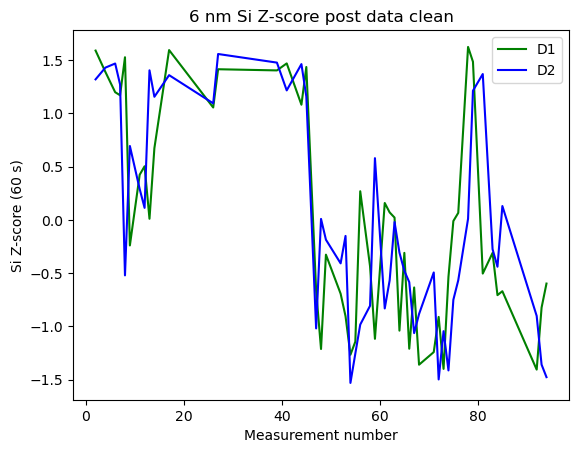

In [13]:
fig, ax = plt.subplots()
ax.plot(D1_filtered.index.values, sp.stats.zscore(D1_f_Z), color = "g", label = 'D1')
ax.plot(D1_filtered.index.values, sp.stats.zscore(D2_f_Z), color = "b", label = 'D2')
ax.set_title(Sample_name + 'Si Z-score post data clean')
ax.set_xlabel('Measurement number')
ax.set_ylabel('Si Z-score (60 s)')
ax.legend()
plt.savefig(ProcessedFigDir + Sample + 'Si_Z-score_post_clean' + '.png', dpi=600)
plt.show()

### Collect mean info for D1
- Create a 6 x 6 array to store HF, Si, and HF/Si mean and uncertainty values
- first column = mean of all 50 values
- second to sixth = mean of 10 values at a time

In [14]:
D1_binned = np.zeros([6,6])
D1_all = D1_filtered[0:50].describe()

mean = D1_all['Hf']['mean'] / D1_all['Si']['mean']

std = np.sqrt(np.square(D1_all['Hf']['std'] / D1_all['Hf']['mean']) +
              np.square(D1_all['Si']['std'] / D1_all['Si']['mean']))* mean

D1_binned[0,:] = (D1_all['Hf']['mean'], 
             D1_all['Hf']['std'], 
             D1_all['Si']['mean'], 
             D1_all['Si']['std'], 
             D1_all['Hf']['mean']/D1_all['Si']['mean'],
             std
            )
D1_binned

array([[1.59276400e+04, 3.31105061e+02, 1.15142352e+06, 3.86558585e+03,
        1.38329987e-02, 2.91287361e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [15]:
Set = D1_filtered[0:10].describe()
mean = Set['Hf']['mean'] / Set['Si']['mean']
std = np.sqrt(np.square(Set['Hf']['std'] / Set['Hf']['mean']) +
              np.square(Set['Si']['std'] / Set['Si']['mean']))* mean
#
D1_binned[1,:] = (Set['Hf']['mean'],
                  Set['Hf']['std'],
                  Set['Si']['mean'],
                  Set['Si']['std'],
                  mean,
                  std)
#                  
Set = D1_filtered[10:20].describe()
mean = Set['Hf']['mean'] / Set['Si']['mean']
std = np.sqrt(np.square(Set['Hf']['std'] / Set['Hf']['mean']) +
              np.square(Set['Si']['std'] / Set['Si']['mean']))* mean
D1_binned[2,:] = (Set['Hf']['mean'],
                  Set['Hf']['std'],
                  Set['Si']['mean'],
                  Set['Si']['std'],
                  mean,
                  std)
# 
Set = D1_filtered[20:30].describe()
mean = Set['Hf']['mean'] / Set['Si']['mean']
std = np.sqrt(np.square(Set['Hf']['std'] / Set['Hf']['mean']) +
              np.square(Set['Si']['std'] / Set['Si']['mean']))* mean
D1_binned[3,:] = (Set['Hf']['mean'],
                  Set['Hf']['std'],
                  Set['Si']['mean'],
                  Set['Si']['std'],
                  mean,
                  std)
Set = D1_filtered[30:40].describe()
mean = Set['Hf']['mean'] / Set['Si']['mean']
std = np.sqrt(np.square(Set['Hf']['std'] / Set['Hf']['mean']) +
              np.square(Set['Si']['std'] / Set['Si']['mean']))* mean
D1_binned[4,:] = (Set['Hf']['mean'],
                  Set['Hf']['std'],
                  Set['Si']['mean'],
                  Set['Si']['std'],
                  mean,
                  std)
#
Set = D1_filtered[40:50].describe()
mean = Set['Hf']['mean'] / Set['Si']['mean']
std = np.sqrt(np.square(Set['Hf']['std'] / Set['Hf']['mean']) +
              np.square(Set['Si']['std'] / Set['Si']['mean']))* mean
D1_binned[5,:] = (Set['Hf']['mean'],
                  Set['Hf']['std'],
                  Set['Si']['mean'],
                  Set['Si']['std'],
                  mean,
                  std)
#
(D1_binned[:, 1]/D1_binned[:, 0])*100,(D1_binned[:, 3]/D1_binned[:, 2])*100,

(array([2.07880804, 1.83926933, 1.50776718, 1.54149803, 3.07254976,
        1.44546496]),
 array([0.33572233, 0.21369541, 0.34556096, 0.19879859, 0.15805533,
        0.32918404]))

### Collect mean info for D2
- Create a 6 x 6 array to store HF, Si, and HF/Si mean and uncertainty values
- first column = mean of all 50 values
- second to sixth = mean of 10 values at a time

In [16]:
D2_binned = np.zeros([6,6])
D2_all = D2_filtered[0:50].describe()

mean = D2_all['Hf']['mean'] / D2_all['Si']['mean']

std = np.sqrt(np.square(D2_all['Hf']['std'] / D2_all['Hf']['mean']) +
              np.square(D2_all['Si']['std'] / D2_all['Si']['mean']))* mean

D2_binned[0,:] = (D2_all['Hf']['mean'], 
             D2_all['Hf']['std'], 
             D2_all['Si']['mean'], 
             D2_all['Si']['std'], 
             D2_all['Hf']['mean']/D2_all['Si']['mean'],
             std
            )
D2_binned

array([[1.56694000e+04, 3.46044824e+02, 1.19057994e+06, 4.45085560e+03,
        1.31611490e-02, 2.94787321e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [17]:
Set = D2_filtered[0:10].describe()
mean = Set['Hf']['mean'] / Set['Si']['mean']
std = np.sqrt(np.square(Set['Hf']['std'] / Set['Hf']['mean']) +
              np.square(Set['Si']['std'] / Set['Si']['mean']))* mean
#
D2_binned[1,:] = (Set['Hf']['mean'],
                  Set['Hf']['std'],
                  Set['Si']['mean'],
                  Set['Si']['std'],
                  mean,
                  std)
#                  
Set = D2_filtered[10:20].describe()
mean = Set['Hf']['mean'] / Set['Si']['mean']
std = np.sqrt(np.square(Set['Hf']['std'] / Set['Hf']['mean']) +
              np.square(Set['Si']['std'] / Set['Si']['mean']))* mean
D2_binned[2,:] = (Set['Hf']['mean'],
                  Set['Hf']['std'],
                  Set['Si']['mean'],
                  Set['Si']['std'],
                  mean,
                  std)
# 
Set = D2_filtered[20:30].describe()
mean = Set['Hf']['mean'] / Set['Si']['mean']
std = np.sqrt(np.square(Set['Hf']['std'] / Set['Hf']['mean']) +
              np.square(Set['Si']['std'] / Set['Si']['mean']))* mean
D2_binned[3,:] = (Set['Hf']['mean'],
                  Set['Hf']['std'],
                  Set['Si']['mean'],
                  Set['Si']['std'],
                  mean,
                  std)
Set = D2_filtered[30:40].describe()
mean = Set['Hf']['mean'] / Set['Si']['mean']
std = np.sqrt(np.square(Set['Hf']['std'] / Set['Hf']['mean']) +
              np.square(Set['Si']['std'] / Set['Si']['mean']))* mean
D2_binned[4,:] = (Set['Hf']['mean'],
                  Set['Hf']['std'],
                  Set['Si']['mean'],
                  Set['Si']['std'],
                  mean,
                  std)
#
Set = D2_filtered[40:50].describe()
mean = Set['Hf']['mean'] / Set['Si']['mean']
std = np.sqrt(np.square(Set['Hf']['std'] / Set['Hf']['mean']) +
              np.square(Set['Si']['std'] / Set['Si']['mean']))* mean
D2_binned[5,:] = (Set['Hf']['mean'],
                  Set['Hf']['std'],
                  Set['Si']['mean'],
                  Set['Si']['std'],
                  mean,
                  std)
#
(D2_binned[:, 1]/D2_binned[:, 0])*100, (D2_binned[:, 3]/D2_binned[:, 2])*100,

(array([2.20841145, 1.65167977, 1.31987216, 2.39664996, 2.96143169,
        1.95835221]),
 array([0.37383929, 0.25435305, 0.32720309, 0.23149245, 0.14967069,
        0.35505502]))

# saving file of intensities and uncertainties
- incuding results from D1 and D2 in a single pickle
- using pickle format

In [18]:
with open( ProcessedDir + Sample + '_Results.pkl', 'wb') as f:
    pkl.dump((D1_binned, D2_binned),f)
f.close()

In [19]:
#with open(Sample + '_Results.pkl', 'rb') as f:
#    D1_binned, D2_binned = pkl.load(f)
#f.close()

## Hafnia intensity plots
- d1 and d2 shown as separate plots

In [20]:
D1_binned[1:,0]

array([15966.8, 16065.6, 15998.6, 15933.5, 15673.7])

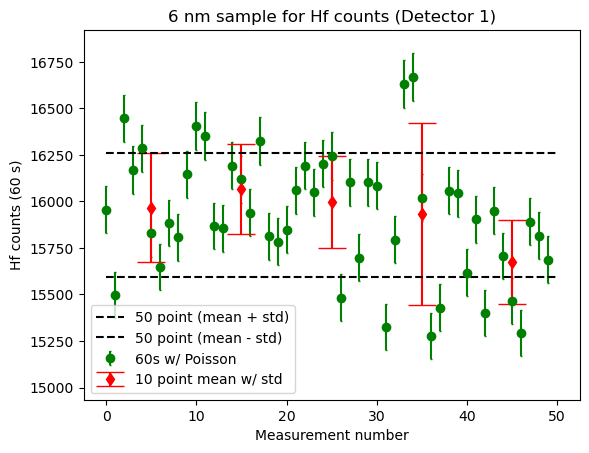

In [21]:
mean = D1_binned[0,0]
std = D1_binned[0,1]
axis1 = np.arange(0,50)
axis10 = np.arange(5,50,10)
#
fig, ax = plt.subplots()
ax.errorbar(axis1,D1_filtered['Hf'], np.sqrt(D1_filtered['Hf']), fmt ='go', capsize=1, label = '60s w/ Poisson')
ax.errorbar(axis10,D1_binned[1:,0], D1_binned[1:,1], fmt = "rd", capsize=10, label = '10 point mean w/ std')
ax.set_title(Sample_name + 'sample for Hf counts (Detector 1)')
ax.set_xlabel('Measurement number')
ax.set_ylabel('Hf counts (60 s)')
ax.plot((0,50), (mean + std, mean + std), 'k--', label = '50 point (mean + std)' )
ax.plot((0,50), (mean - std, mean -std), 'k--', label = '50 point (mean - std)' )
ax.legend()
plt.ylim([mean- 3*std, mean + 3*std])
plt.savefig(ProcessedFigDir + Sample + 'Hf_intensity_D1' + '.png', dpi=600)
plt.show()

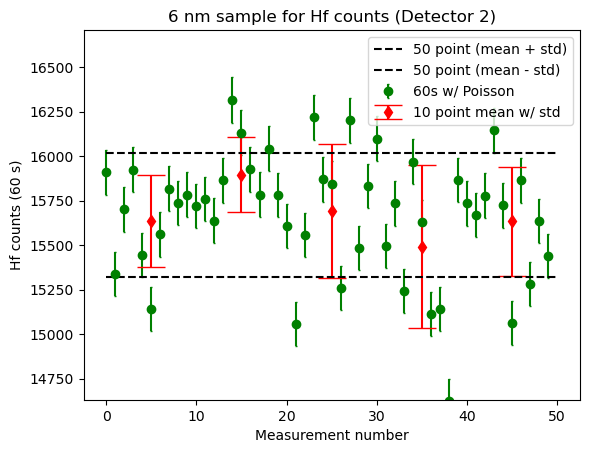

In [22]:
mean = D2_binned[0,0]
std = D2_binned[0,1]
axis1 = np.arange(0,50)
axis10 = np.arange(5,50,10)
#
fig, ax = plt.subplots()
ax.errorbar(axis1,D2_filtered['Hf'], np.sqrt(D2_filtered['Hf']), fmt ='go', capsize=1, label = '60s w/ Poisson')
ax.errorbar(axis10,D2_binned[1:,0], D2_binned[1:,1], fmt = "rd", capsize=10, label = '10 point mean w/ std')
ax.set_title(Sample_name + 'sample for Hf counts (Detector 2)')
ax.set_xlabel('Measurement number')
ax.set_ylabel('Hf counts (60 s)')
ax.plot((0,50), (mean + std, mean + std), 'k--', label = '50 point (mean + std)' )
ax.plot((0,50), (mean - std, mean -std), 'k--', label = '50 point (mean - std)' )
ax.legend()
plt.ylim([mean- 3*std, mean + 3*std])
plt.savefig(ProcessedFigDir + Sample + 'Hf_intensity_D2' + '.png', dpi=600)
plt.show()

# Si intensity plots
- separate plots for D1 and D2

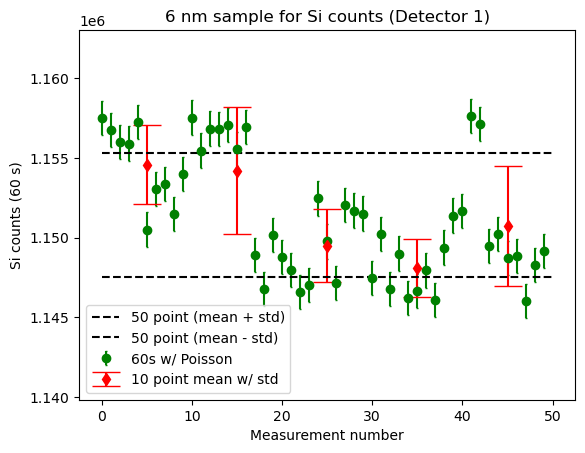

In [23]:
mean = D1_binned[0,2]
std = D1_binned[0,3]
axis1 = np.arange(0,50)
axis10 = np.arange(5,50,10)
#
fig, ax = plt.subplots()
ax.errorbar(axis1,D1_filtered['Si'], np.sqrt(D1_filtered['Si']), fmt ='go', capsize=1, label = '60s w/ Poisson')
ax.errorbar(axis10,D1_binned[1:,2], D1_binned[1:,3], fmt = "rd", capsize=10, label = '10 point mean w/ std')
ax.set_title(Sample_name + 'sample for Si counts (Detector 1)')
ax.set_xlabel('Measurement number')
ax.set_ylabel('Si counts (60 s)')
ax.plot((0,50), (mean + std, mean + std), 'k--', label = '50 point (mean + std)' )
ax.plot((0,50), (mean - std, mean -std), 'k--', label = '50 point (mean - std)' )
ax.legend()
plt.ylim([mean- 3*std, mean + 3*std])
plt.savefig(ProcessedFigDir + Sample + 'Si_intensity_D1' + '.png', dpi=600)
plt.show()

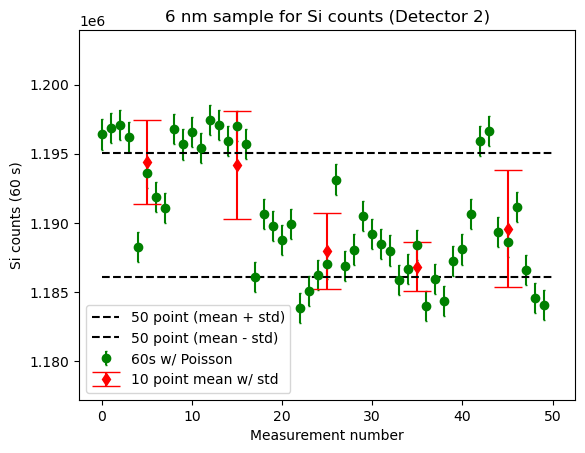

In [24]:
mean = D2_binned[0,2]
std = D2_binned[0,3]
axis1 = np.arange(0,50)
axis10 = np.arange(5,50,10)
#
fig, ax = plt.subplots()
ax.errorbar(axis1,D2_filtered['Si'], np.sqrt(D2_filtered['Si']), fmt ='go', capsize=1, label = '60s w/ Poisson')
ax.errorbar(axis10,D2_binned[1:,2], D2_binned[1:,3], fmt = "rd", capsize=10, label = '10 point mean w/ std')
ax.set_title(Sample_name + 'sample for Si counts (Detector 2)')
ax.set_xlabel('Measurement number')
ax.set_ylabel('Si counts (60 s)')
ax.plot((0,50), (mean + std, mean + std), 'k--', label = '50 point (mean + std)' )
ax.plot((0,50), (mean - std, mean -std), 'k--', label = '50 point (mean - std)' )
ax.legend()
plt.ylim([mean- 3*std, mean + 3*std])
plt.savefig(ProcessedFigDir + Sample + 'Si_intensity_D2' + '.png', dpi=600)
plt.show()

# Hf/Si ratio plots
-repeated for D1 and D2

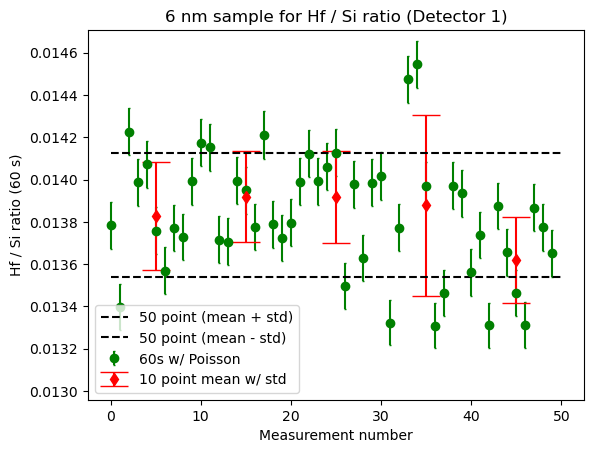

In [25]:
mean = D1_binned[0,4]
std = D1_binned[0,5]
axis1 = np.arange(0,50)
axis10 = np.arange(5,50,10)
D1_ratio = D1_filtered['Hf']/ D1_filtered['Si']
D1_std = np.sqrt(np.square(np.sqrt(D1_filtered['Hf'])/D1_filtered['Hf']) + 
                 np.square(np.sqrt(D1_filtered['Si'])/D1_filtered['Si']))* D1_ratio
#
fig, ax = plt.subplots()
ax.errorbar(axis1,D1_ratio, D1_std, fmt ='go', capsize=1, label = '60s w/ Poisson')
ax.errorbar(axis10,D1_binned[1:,4], D1_binned[1:,5], fmt = "rd", capsize=10, label = '10 point mean w/ std')
ax.set_title(Sample_name + 'sample for Hf / Si ratio (Detector 1)')
ax.set_xlabel('Measurement number')
ax.set_ylabel('Hf / Si ratio (60 s)')
ax.plot((0,50), (mean + std, mean + std), 'k--', label = '50 point (mean + std)' )
ax.plot((0,50), (mean - std, mean -std), 'k--', label = '50 point (mean - std)' )
ax.legend()
plt.ylim([mean- 3*std, mean + 3*std])
plt.savefig(ProcessedFigDir + Sample + 'Hf_over_Si_intensity_D1' + '.png', dpi=600)
plt.show()

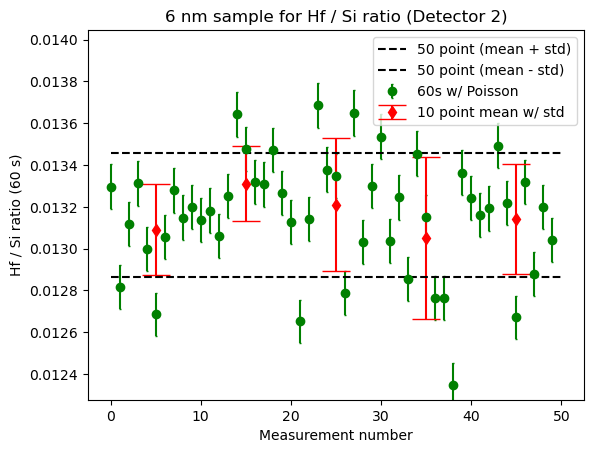

In [26]:
mean = D2_binned[0,4]
std = D2_binned[0,5]
axis1 = np.arange(0,50)
axis10 = np.arange(5,50,10)
D2_ratio = D2_filtered['Hf']/ D2_filtered['Si']
D2_std = np.sqrt(np.square(np.sqrt(D2_filtered['Hf'])/D2_filtered['Hf']) + 
                 np.square(np.sqrt(D2_filtered['Si'])/D2_filtered['Si']))* D2_ratio
#
fig, ax = plt.subplots()
ax.errorbar(axis1,D2_ratio, D2_std, fmt ='go', capsize=1, label = '60s w/ Poisson')
ax.errorbar(axis10,D2_binned[1:,4], D2_binned[1:,5], fmt = "rd", capsize=10, label = '10 point mean w/ std')
ax.set_title(Sample_name + 'sample for Hf / Si ratio (Detector 2)')
ax.set_xlabel('Measurement number')
ax.set_ylabel('Hf / Si ratio (60 s)')
ax.plot((0,50), (mean + std, mean + std), 'k--', label = '50 point (mean + std)' )
ax.plot((0,50), (mean - std, mean -std), 'k--', label = '50 point (mean - std)' )
ax.legend()
plt.ylim([mean- 3*std, mean + 3*std])
plt.savefig(ProcessedFigDir + Sample + 'Hf_over_Si_intensity_D2' + '.png', dpi=600)
plt.show()